# Deep Learning vs Traditional ML (Logistic Regression) Camprison Notebook

Now that we have trained LTSM with 2 million samples on Google Colab, we are going to compare the results with our traditional ML model (Logistic Regression)

We know that Logistic Regression's performance plateaus after about 200k samples and we know that LSTM is not performing as well as Logistic Regression with only 200k samples. 2 million is around the limit where we can use Google Colab to train our models while still working within the 24 hour backend limit. Further training for LSTM will probably have to be done on GCP using one of the GPU based compute instances.

We will take the results that we have so far to see if it's worth our while to keep training LSTM with more examples on GCP.


## Traditional ML Model

* Model: Logistic Regression
* Class weights: balanced
* Features: TF-IDF with 4k features
* Sample Size: 50k to 9mil

## Deep Learning Model

* Architecture: LSTM
* Class weights: balanced
* LSTM Nodes: 64
* Input Layer: Random Embedding (300)
* Sample Size: 50k to 2mill


    
# Conclusion

We good improvement (~ 0.6) in our score between 200k samples and 500k samples. However, improvement in our model between 500k samples to 1 million samples was minimal (0.017). We also saw a decrease in score (~ 0.03) between 500k and 1 million samples

Looking at the classification report more closely, we see that when score decreases with more samples, we generally see 2-star rating and 4-star rating recall decrease. We also see a slight decrease in accuracy in 1-star ratings. Generally, accuracy for 2-star and 4-star rating stays roughly the same (maybe with some slight improvements)





In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

Load PySpark LR Report

In [2]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_LR = f'{REPORT_DIR}/201911-pyspark-report.csv'


report_lr = pd.read_csv(REPORT_LR, quotechar="'")
# flatten out classification report so we can graph later
report_lr = ru.convert_dnn_report_format(report_lr)

# calculate our custom score
report_lr["eval_metric"] = report_lr.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


ModelWrapper names the reports besed on run date so far. This has to be refactored. Some of the LSTM training was done in 11/2019 and others in 1/2020. Until then, we will merge 2 reports together into one


In [3]:
# runs from 11/2019
REPORT_LSTM_1 = f'{REPORT_DIR}/2019-11-dl_prototype-report.csv'
# runs from 1/2020
REPORT_LSTM_2 = f'{REPORT_DIR}/2020-01-dl_prototype-report.csv'

report_dnn = pd.read_csv(REPORT_LSTM_1, quotechar="'")
report_dnn = report_dnn.append(pd.read_csv(REPORT_LSTM_2, quotechar="'"), ignore_index=True, sort=False)



# report_lstm = report_dnn[(report_dnn.model_name == "LSTMB") & (report_dnn.sampling_type.isna())]
report_lstm64 = report_dnn[(report_dnn.model_name == "LSTMB") & (report_dnn.sampling_type == "none")].copy()
report_lstm64 = ru.convert_dnn_report_format(report_lstm64)

# calculate our custom score
report_lstm64["eval_metric"] = report_lstm64.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



Runs for LSTMB without dropout was done in 2/2020 so it's in a separate file

In [4]:
REPORT_LSTM_NODROP = f'{REPORT_DIR}/2020-02-dl_prototype-report.csv'

report202002 = pd.read_csv(REPORT_LSTM_NODROP, quotechar="'")
report202002 = ru.convert_dnn_report_format(report202002)
report202002["eval_metric"] = report202002.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



report_lstm64_nodrop = report202002[report202002.model_name.str.startswith("LSTMB_nodrop")]
report_lstm32 = report202002[report202002.model_name == "LSTMB32"]
report_lstm16 = report202002[report202002.model_name == "LSTMB16"]


report_lstm_removed_all_dropout = pd.read_csv(f'{REPORT_DIR}/lstm_remove_all_dropout-dl_prototype-report.csv', quotechar="'")
report_lstm_removed_all_dropout = ru.convert_dnn_report_format(report_lstm_removed_all_dropout)
report_lstm_removed_all_dropout["eval_metric"] = report_lstm_removed_all_dropout.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



Added 4/2020 - ran LSTM network with 128 nodes

* Glove embedding with 300 dimension vectors
* max sequence length of 100 words (this is same as what we've been doing)
* 128 LSTM hidden units with 0.2 dropout rate
* learning rate of 0.01
* batch size of 32
* 20 epochs with early stopping

In [12]:
# LSTMB128
report_lstmb128 = pd.read_csv(f'{REPORT_DIR}/glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128 = report_lstmb128[report_lstmb128.model_name == "LSTMB128"]
report_lstmb128 = ru.convert_dnn_report_format(report_lstmb128)
report_lstmb128["eval_metric"] = report_lstmb128.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_lstmb128

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,tokenizer_file,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,weights_file,eval_metric
0,0.708656,0.700351,0.717160,6958.0,0.327358,0.283673,0.386947,3233.0,0.390443,0.350052,...,drive/My Drive/Springboard/capstone/models/LST...,149653.0,100.0,145.65,0.664187,0.681168,0.651939,49885.0,drive/My Drive/Springboard/capstone/models/LST...,0.508309
1,0.656386,0.648276,0.664702,1697.0,0.285278,0.242634,0.346106,809.0,0.300136,0.324165,...,drive/My Drive/Springboard/capstone/models/LST...,37415.0,100.0,54.03,0.624986,0.637520,0.615940,12472.0,drive/My Drive/Springboard/capstone/models/LST...,0.428784
2,0.708820,0.747235,0.674161,17435.0,0.369994,0.307112,0.465256,8131.0,0.404698,0.362695,...,drive/My Drive/Springboard/capstone/models/LST...,374123.0,100.0,390.37,0.677885,0.698226,0.663871,124708.0,drive/My Drive/Springboard/capstone/models/LST...,0.545078
3,0.696320,0.686964,0.705934,3404.0,0.308824,0.280415,0.343636,1650.0,0.332970,0.346800,...,drive/My Drive/Springboard/capstone/models/LST...,74829.0,100.0,80.74,0.649623,0.660117,0.641703,24943.0,drive/My Drive/Springboard/capstone/models/LST...,0.457150


### Evaluation Metrics

In [6]:
report_lr[["train_examples", "eval_metric"]]

,train_examples,eval_metric
0,44726.0,0.422127
1,89544.0,0.454550
2,179168.0,0.483252
3,447989.0,0.499181
4,896004.0,0.507036
5,1799736.0,0.514962
6,3599433.0,0.515266
7,8064337.0,0.517467


In [7]:
report_lstm64[["train_examples", "eval_metric"]].sort_values("train_examples")

,train_examples,eval_metric
0,149350.0,0.333960
2,448051.0,0.394009
3,896119.0,0.395784
1,1800000.0,0.367591


In [13]:
report_lstmb128[["train_examples", "eval_metric"]].sort_values("train_examples")

,train_examples,eval_metric
1,37415.0,0.428784
3,74829.0,0.457150
0,149653.0,0.508309
2,374123.0,0.545078


# Custom Metric For Various Architectures

All models uses balaned weight class to give higher weights for accuracy for minority classes


| Name | LSTM Units | Spatial Droput between Embedding and LSTM Layer | LSTM Dropout |
|------|--------------|-------------------------------------------------|--------------|
| LRB | N/A | N/A | N/A |
| LSTMb64 | 64 | 20% | 20% |
| LSTMB64 (No Dropout) | 64 | 20% | N/A |
| LSTMB32 (No Dropout) | 32 | 20% | N/A |
| LSTMB16 (No Dropout) | 16 | 20% | N/A |
| LSTMB16 (Removed All Dropouts) | 16 | N/A | N/A |
| LSTMB128 | 128 | N/A | 0.2 (recurrant) |


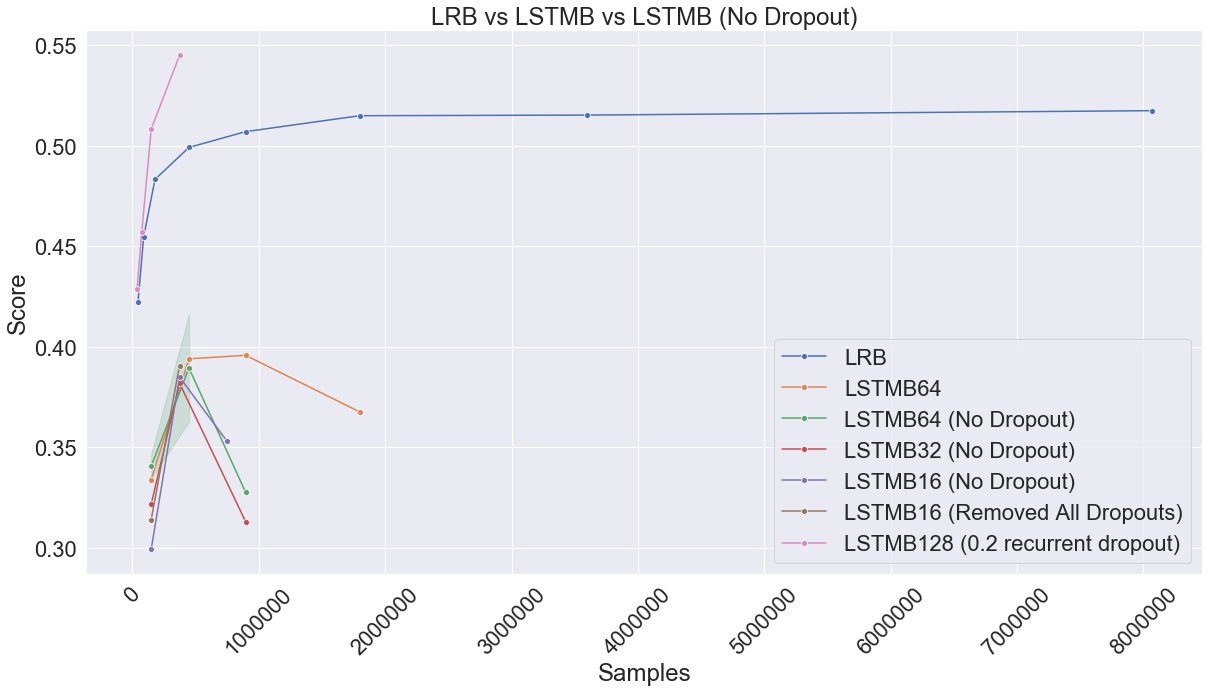

In [15]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="LRB")
sns.lineplot(data=report_lstm64, x="train_examples", y="eval_metric", marker="o", label="LSTMB64")
sns.lineplot(data=report_lstm64_nodrop, x="train_examples", y="eval_metric", marker="o", label="LSTMB64 (No Dropout)")
sns.lineplot(data=report_lstm32, x="train_examples", y="eval_metric", marker="o", label="LSTMB32 (No Dropout)")
sns.lineplot(data=report_lstm16, x="train_examples", y="eval_metric", marker="o", label="LSTMB16 (No Dropout)")
sns.lineplot(data=report_lstm_removed_all_dropout, x="train_examples", y="eval_metric", marker="o", label="LSTMB16 (Removed All Dropouts)")
sns.lineplot(data=report_lstmb128, x="train_examples", y="eval_metric", marker="o", label="LSTMB128 (0.2 recurrent dropout)")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Score")
_ = plt.title("LRB vs LSTMB vs LSTMB (No Dropout)")




# Let's look at the classification report more closely between Logistic Regression and LSTM (128 cells)

REMINDER: we are using precision for 1-star and 5-star, and recall for 2-star, 3-star, and 4-star reviews to calculate our custom metric. Tradtionally, we have seen that increasing 2-star recall has been challenging, mostly because we have the least amount of samples available to use for training in this category

* generally we are seeing 2-star, 3-star, 4-star recall increase as we provide more samples for training for LSTMB
* Staring around 500k samples, we see that LSTMB precision for 1-star reviews starts to exceed LRB
* Recall for 2-star reviews with just 50k samples is around the same as training LRB with 9mil examples and stars to exceed LRB with just 100k examples
* 3-star recall starts to exceed LRB around 200k samples and was approximately the same as we increased to 500k samples
* 4-star recall with 500k samples for LSTMB is roughly the same as training LRB with 9mil examples
* Precision for 5-star reviews are roughly the same between LRB and LSTMB

Also, another thing interesting to note, starting at around 500k samples for LSTMB, we are seeing 2-star review recall exceeding 3-star and 4-star recall that we have not seen before.

Logistic Regression (Balanced Weight) with 9 Million Examples


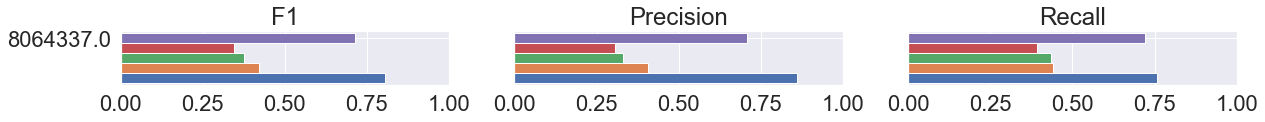

In [25]:
import util.plot_util as pu
print("Logistic Regression (Balanced Weight) with 9 Million Examples")
pu.plot_score_histograms(report_lr[report_lr.train_examples == report_lr.train_examples.max()], version=2, label="train_examples")

LSTM (128 Units 20% Recurrent Dropout)


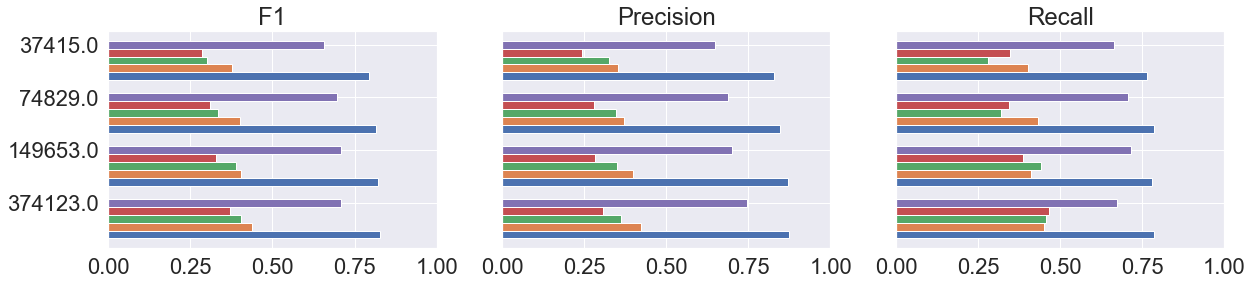

In [22]:
print("LSTM (128 Units 20% Recurrent Dropout)")
pu.plot_score_histograms(report_lstmb128, version=2, label="train_examples")